In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
import numpy as np
import pandas as pd
from onward import utils, eda, feature_engineering as fe
pd.set_option("display.show_dimensions", False)
warnings.filterwarnings("ignore")

## 1. Motivation

When designing effective demand response (DR) programs, it is crucial to consider a range of factors and objectives. We adopt an explainable approach to data categorization, creating partitions based on domain expertise rather than relying solely on a single, black-box clustering method. This allows us to address the fundamental question: What makes a good DR program?

A good DR program can be evaluated through multiple lenses. Firstly, it should achieve specific objectives such as load smoothing and ramp reduction, which necessitate identifying patterns in consumer load. These patterns are influenced by variables like time of year, day of the week, and time of day, which significantly affect total energy consumption and its variations.

Another key measure of a DR program's effectiveness is its size, which must be sufficient in capacity (total or maximum energy consumption) to meaningfully impact the grid. Consequently, one of our partitions differentiates between large and small consumers. However, equity is also a vital consideration. If only a few large consumers can participate and benefit, the program lacks fairness. Our analysis indicates that over 50% of our dataset comprises small consumers who traditionally might be excluded from DR programs. We propose grouping these smaller consumers and pairing them with an aggregator who can coordinate their consumption and distribute the program's financial benefits. This approach ensures a more inclusive and equitable participation in the program.

By designing partitions based on domain expertise and considering factors such as load patterns, program size, and equity, we aim to create effective and fair DR programs that benefit both consumers and the grid.

## 2. Data Partition
To create effective demand response (DR) programs, we must partition the energy consumption data of buildings into meaningful categories. This partitioning facilitates the identification of distinct consumption patterns and enhances the program's effectiveness. For this particular case, we will partition the data based on three main criteria: the size of energy consumption, seasonal energy consumption, and daily energy patterns  [[1]](#Paper).

* Size of Energy Consumption: By distinguishing between large and small consumers, we can tailor the DR program to address the different impacts these groups have on the grid. Large consumers have a significant effect on overall energy demand, while small consumers, when aggregated, can also play a crucial role.

* Seasonal Energy Consumption: Energy usage varies with the seasons due to changes in weather, daylight hours, and occupancy patterns. Partitioning data by season allows us to account for these variations and design DR strategies that are effective year-round.

* Daily Energy Patterns: Energy consumption differs throughout the day, influenced by factors such as business hours, residential activities, and temperature fluctuations. By examining daily patterns, we can identify peak periods and potential opportunities for load shifting.

The goal of these partitions is to gain meaningful insights that enable us to create well-defined data clusters. These clusters will then be used to develop DR programs that are both effective in reducing load and equitable in their benefits. By considering the size of energy consumption, seasonal variations, and daily patterns, we can design DR programs that better serve the needs of both consumers and the grid.

## 2.1 Large vs Small Consumers
First, let's look at the distribution total energy consumed by the buildings. In particular, let's look at the relationship between the largest buildings and much energy they consume. [Plot 1](#Distribution) shows that the distribution of total energy consumption has a very long-tail which means that most buildings are small and consume relatively little energy a few very large buildings consume most of the energy. Concretely, the top 5% of buildings (as measured by energy consumption) consume more than 55% of the total energy. On the other hand, the bottom 50% of buildings consume less than 1% of the total energy. This large disparity has important implications for the equity of DR programs.

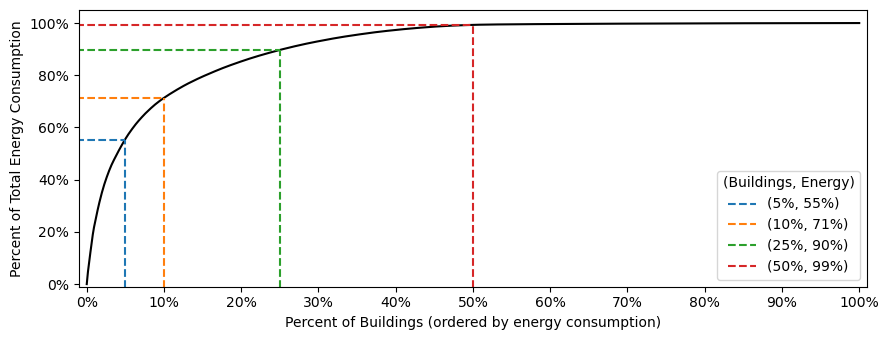

In [3]:
data_dict = {i: utils.load_building_data(i) for i in range(1, 1278)}
cluster_data = pd.DataFrame(dict(building_num = range(1, 1278)))
cluster_data["total_energy_consumption"] = fe.get_size_feature(data_dict)

eda.plot_size_ecdf(cluster_data.total_energy_consumption.values)

<a id="Distribution"></a>
<div style="text-align: center;">
    <h2>Plot 1: Distribution of Energy Consumption </h2>
</div>

Now we will model energy consumption as a decomposition into two time-dependent components, one that varies slowy and captures time of year patterns and the other that repeats every week and captures time of day and day of week patterns. We show the model's predictions for the total group consumption in Plot 2 in the orange line. The green line is a 30-day centered moving average and the black line shows the weekly adjustment which fits the residual after subtracting the moving average.  

In [4]:
is_large = cluster_data.total_energy_consumption > np.median(cluster_data.total_energy_consumption)
cluster_data["total_consumption_group"] = np.where(is_large, "large", "small")

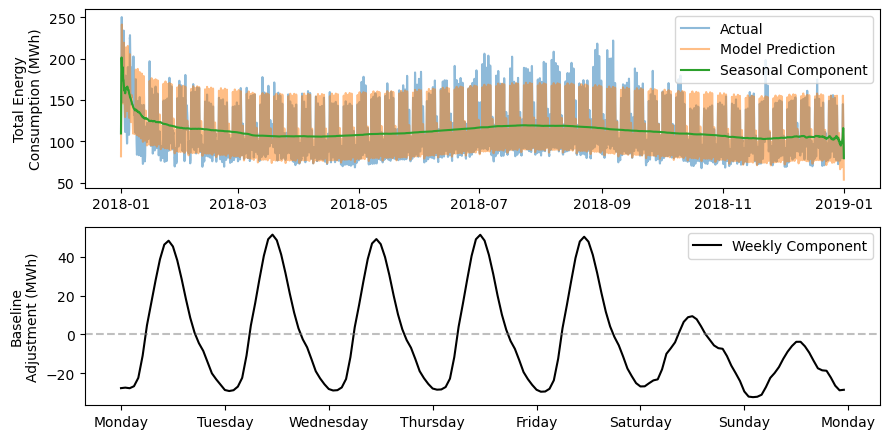

In [5]:
total = data_dict[1].copy()
for i in range(2,1278):
    df = data_dict[i]
    total.energy_consumption += df.energy_consumption

eda.plot_time_dependent_components(total)    

<a id="Yearly"></a>
<div style="text-align: center;">
    <h2>Plot 2: (Top) Total Energy Consumption, (Bottom) Weekly Component</h2>
</div>

## 2.2 Seasonal Energy Consumption
Next, let's look at the relationship between energy consumption and time. The [Plot 2](#Yearly) shows that there is a significant energy consumption increase during summer and winter. A deeper analysis for energy consumption during summer and winter would give us a better understanding of the data. Since some buildings can have both a summer and winter peak, we will use a soft clustering procedure: 

1. Calculate seasonal features (30-day centered average)
2. Create "hard clusters" using k-means
3. Fit a logistic regression model to predict the cluster label probability
4. Define "soft clusters" (rather than assigning a building to one and only one cluster, we get cluster membership probabilities)

First we figure out the cutoff probabilities. Fortunately, these clusters are easy to predict and there are two well-defined "elbows" in the data thus making it easy to partition the summer peak and winter peak as shown in [Plot 3](#probability).

In [6]:
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression

# step 1: calculate seasonal features
raw_seasonal_features, seasonal_features = fe.get_seasonal_features(data_dict)

# step 2: cluster data
#   note we discard the first and last two weeks because they do not contain
#   a full window of data (that is, they are bad estimates of seasonality)
kmeans = KMeans(n_clusters=2, n_init=25, random_state=0)
seasonal_cluster_labels = kmeans.fit_predict(seasonal_features[:,14:-14])  

# step 3: fit logistic regression model
classifier = LogisticRegression(random_state=0)
classifier.fit(seasonal_features[:,14:-14:14], seasonal_cluster_labels)
cluster1_prob = classifier.predict_proba(seasonal_features[:,14:-14:14])[:,1]  # probability of cluster 1

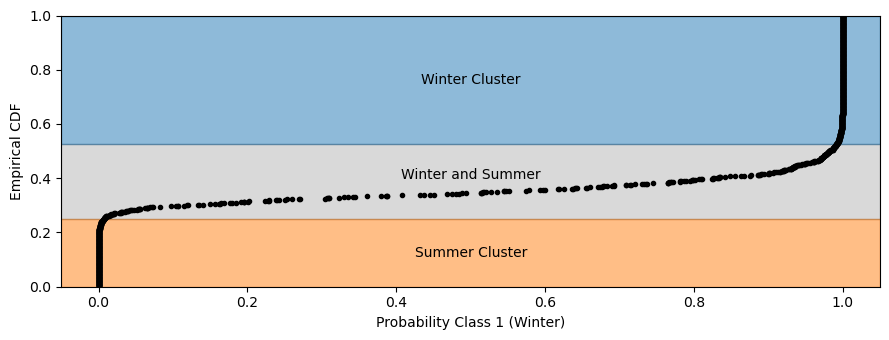

In [7]:
# step 4: get cluster probabilities
q_summer, q_winter = 0.25, 0.525
p_summer, p_winter = np.quantile(cluster1_prob, [q_summer, q_winter])
eda.plot_seasonal_ecdf(cluster1_prob, q_winter, q_summer)    

<a id="probability"></a>
<div style="text-align: center;">
    <h2>Plot 3: Cutoff Probabilities</h2>
</div>

At [Plot 4](#Top3Seasonal), we've labeled cluster 1 as winter and 0 as summer. Now let's see the plot of the top 3 buildings with the highest cluster probabilities for each cluster. The first column shows the builddings with the highest cluster 1 probability, the third column corresponds to buildings with highest cluster 0 probability, the second column corresponds to the buildings in the gray area. Clearly, cluster 1 corresponds to winter peaking load, cluster 0 corresponds to summer peaking load, and the gray area is difficult to classify. Let's look at the distribution of each cluster.

The winter peak cluster has a much larger (positive) normalized consumption during the winter and almost all negative values during the summer. The summer peak cluster has larger normalized consumption during the summer and almost all negative values during the winter. The winter and summer cluster is somewhere in between.

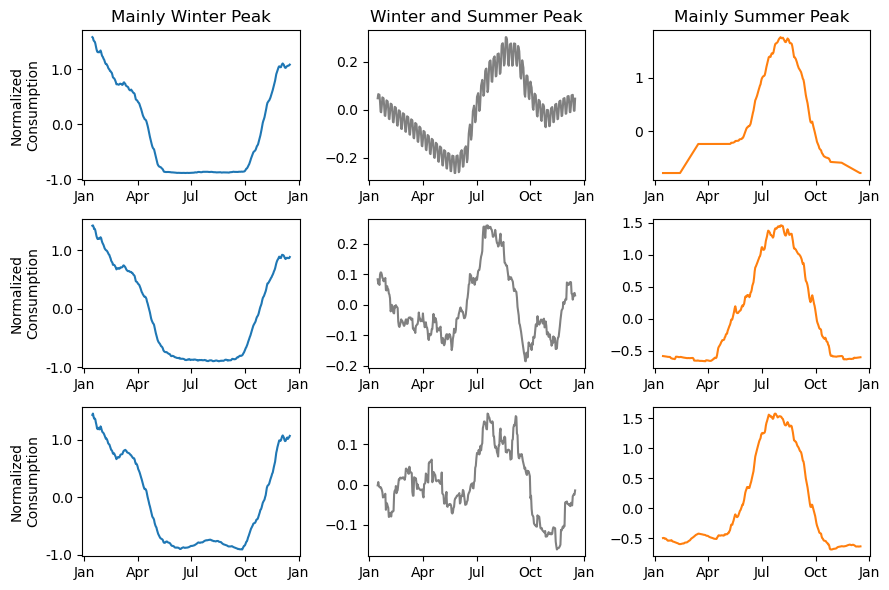

In [8]:
eda.plot_seasonal_top3(cluster1_prob, seasonal_features, q_winter, q_summer)

<a id="Top3Seasonal"></a>
<div style="text-align: center;">
    <h2>Plot 4: Top 3 Building Energy Concumption (1st Column) Winter Peak, (2nd Column) Winter & Summer Peak, (3rd Column) Summer Peak </h2>
</div>

We now plot all the building seasonal patterns in a single plot. The blue lines show individual buildings in a cluster and the orange line shows the cluster average. 

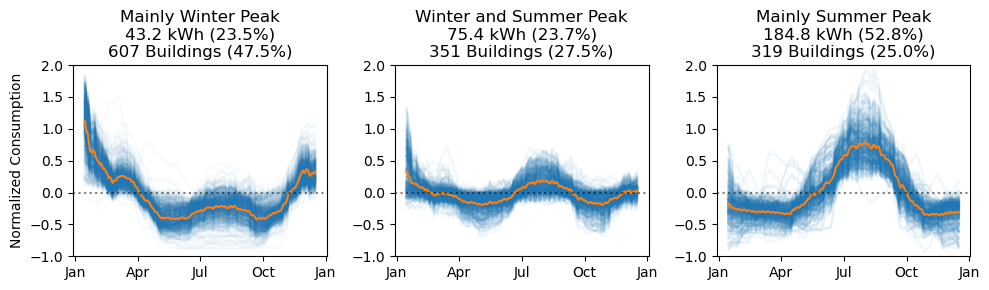

In [9]:
is_summer_peak = cluster1_prob < p_summer  # mainly summer
is_winter_peak = cluster1_prob > p_winter  # mainly winter
is_both_peak = (cluster1_prob >= p_summer) & (cluster1_prob <= p_winter)
eda.plot_seasonal_cluster_distribution(raw_seasonal_features, seasonal_features, is_winter_peak, is_both_peak, is_summer_peak)

<a id="Normalized Seasonal"></a>
<div style="text-align: center;">
    <h2>Plot 5: Normalized Energy Concumption  (1st Column) Winter Peak, (2nd Column) Winter & Summer Peak, (3rd Column) Summer Peak </h2>
</div>

In [10]:
# add seasonal clusters to results
cluster_data["summer_consumption_group"] = np.where(cluster1_prob < p_winter, "summer_peak", "no_summer_peak")
cluster_data["winter_consumption_group"] = np.where(cluster1_prob > p_summer, "winter_peak", "no_winter_peak")

## 2.3 Daily Energy Consumption Patterns
Let's use simple $k$-means to get the clusters as shwon in [Plot 6](#DailyCluster) [[3]](#Paper). To get an idea of how many clusters we should use, let's visualize the average normalized consumption for each cluster. Although there is a meaningful difference between $k$-means with two clusters, $k$-means with three clusters gives us an additional midday trough cluster which can be useful for certain types of DR programs. $k$-means with four clusters seems like too much since it splits the midday peak into two roughly similar clusters. Let's explore these three clusters in more detail.

[Plot 7](#DailyPattern) shows that the midday peak cluster has both high energy consumption and a significant number of buildings. Targeting these buildings will greatly enhance the success of the DR program. The evening peak cluster, while containing the largest number of buildings, has much lower energy consumption compared to the midday peak. This pattern correlates strongly with the distribution shown in [Plot 1](#Distribution), where 50% of the buildings consume only 1% of the total energy. Despite their low individual consumption, these buildings should not be ignored to achieve energy equity.

Examining the midday trough cluster more closely, individual plots of each building reveal a mix of morning and evening peaks, but with a consistent dip in energy consumption during midday. This suggests that these buildings may have solar panels installed, thus reducing net energy consumption during midday when solar energy is abundant. In summary, by focusing on these three distinct clusters (midday peak, evening peak, and midday trough) we can design DR programs that effectively target high-consumption periods while also promoting equitable participation across all building types.

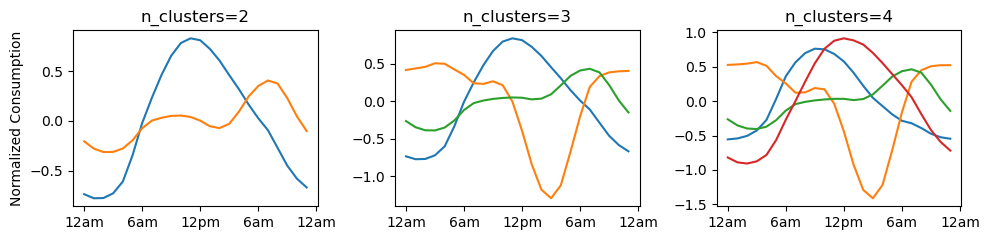

In [11]:
raw_daily_features, daily_features = fe.get_daily_features(data_dict)
eda.plot_tod_n_clusters(daily_features)    

<a id="DailyCluster"></a>
<div style="text-align: center;">
    <h2>Plot 6: Cluster Partition (1st Column) 2 Clusters, (2nd Column) 3 Clusters, (3rd Column) 4 Clusters </h2>
</div>

Again, let's visualize all the buildings in each cluster.

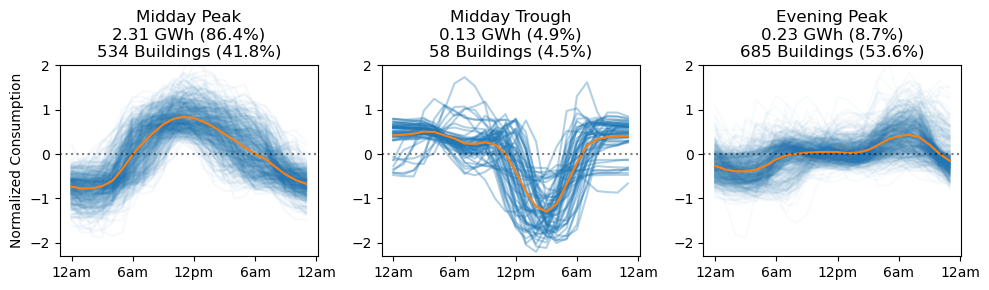

In [12]:
tod_cluster_model = KMeans(n_clusters=3, n_init="auto", random_state=0)
tod_cluster_labels = tod_cluster_model.fit_predict(daily_features)
eda.plot_tod_cluster_distribution(raw_daily_features, daily_features, tod_cluster_labels)

<a id="DailyPattern"></a>
<div style="text-align: center;">
    <h2>Plot 7: Daily Enegry Pattern (1st Column) Midday Peak, (2nd Column) Midday Through, (3rd Column) Evening Peak </h2>
</div>

In [13]:
# add time of day clusters to results
tod_cluster_map = {0:"midday_peak", 1:"midday_trough", 2:"evening_peak"}
cluster_data["time_of_day_consumption_group"] = pd.Series(tod_cluster_labels).map(tod_cluster_map)

## 3. Analysis

Recall, we created following categorical features
* `total_consumption_group`: partitions the buildings into 2 groups (`small` and `large`) based on total energy consumption 
* `time_of_day_consumption_group`: partitions the buildings into 3 time-of-day groups (`midday_peak`, `midday_trough`, and `evening_peak`)
* `summer_consumption_group`: partitions the buildings into 2 groups (`summer_peak` and `no_summer_peak`) based on whether they have an increase in energy consumption during the summer or not
* `winter_consumption_group`: partitions the buildings into 2 groups (`winter_peak` and `no_winter_peak`) based on whether they have an increase in energy consumption during the winter or not

We can technically create a total of 24 (2 × 2 × 2 × 3) clusters by calculating the intersection of all the groups. However, some of these clusters will likely be small in terms of the number of buildings and/or total energy consumption, making them unsuitable for a DR program. We will now explore the feasibility of these clusters and select the most promising ones.

As shown in [Table  1](#Combination), out of the 24 possible combinations, only 17 have buildings. When creating a DR program, the number of clusters should not be too high because it becomes impractical and hard to implement. Therefore, good engineering and technical judgment must be used to reduce the number of clusters while still maintaining a positive impact on the DR program. Based on this mindset, we aim to reduce the number of clusters to six or fewer.

The easiest way to split the buildings into several clusters is to see whether they consume large amounts of energy or not. Large energy consumption may imply commercial buildings, while small energy consumption may imply residential buildings. A deeper analysis of the large buildings reveals three clusters: midday peak, evening peak, and midday trough. Both large and small buildings can also be divided into summer and winter peaks.

When creating an effective DR program, buildings must be clustered based on similarity. Large commercial buildings have different load and energy consumption patterns compared to residential buildings. Similarly, seasonal effects must also be considered as they affect peak consumption during different times of the year. A pie chart, shown in  [Plot 8](#PieChart), visualizes the energy consumption of small and large buildings in an easy-to-understand manner. Small buildings are mostly in the evening peak category, with non-evening peak buildings being very few, making it hard to justify a separate cluster for them. On the other hand, evening peak buildings account for almost half of the total buildings, so we can still separate them into summer and winter peaks due to different energy consumption patterns depending on the time of the year.

Large buildings are mostly in the midday peak category, which is understandable since most of them are commercial buildings. Although the number of buildings in the evening and midday trough categories is smaller compared to midday peak, their total energy consumption is significant enough to justify creating separate clusters for them. For the evening peak category, we assume these are residential buildings, so we can separate large evening peak buildings further into summer and winter clusters. Since small and large evening peak buildings have similar consumption patterns, we can combine them into one cluster.

Please note that some buildings may appear in more than one cluster, e.g., a building can be in both the large evening peak summer and large evening peak winter categories. We allow this partition since we don't want to limit the participation of buildings in the DR program. The hierarchical clustering is well depicted in [Figure 1](#Hierarchy).


<a id="Combination"></a>
<div style="text-align: center;">
    <h2>Table 1: Possible Combination</h2>
</div>

In [14]:
utils.display_dataframe(
    cluster_data.groupby(["total_consumption_group", "time_of_day_consumption_group", "summer_consumption_group", "winter_consumption_group"])
        .agg(total_energy_consumption=("total_energy_consumption", "sum"), count=("total_energy_consumption", "count"))
        .sort_values(["total_consumption_group", "count"], ascending=[True, False])
        .reset_index()
)

total_consumption_group,time_of_day_consumption_group,summer_consumption_group,winter_consumption_group,total_energy_consumption,count
large,midday_peak,summer_peak,winter_peak,1.889504e+08,178
large,midday_peak,no_summer_peak,winter_peak,1.765899e+08,172
large,midday_peak,summer_peak,no_winter_peak,4.755082e+08,146
large,evening_peak,no_summer_peak,winter_peak,4.289523e+07,64
large,midday_trough,summer_peak,no_winter_peak,3.089571e+07,27
large,midday_trough,summer_peak,winter_peak,1.303745e+07,17
large,evening_peak,summer_peak,winter_peak,2.707877e+07,14
large,evening_peak,summer_peak,no_winter_peak,9.383205e+06,11
large,midday_trough,no_summer_peak,winter_peak,3.503463e+06,9
small,evening_peak,no_summer_peak,winter_peak,3.949312e+06,341


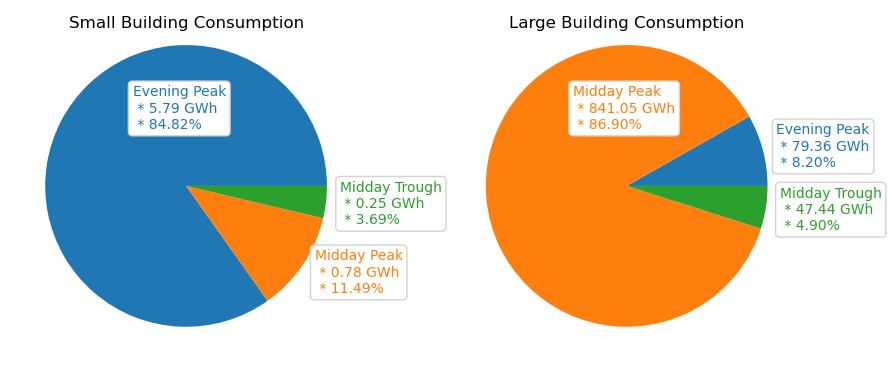

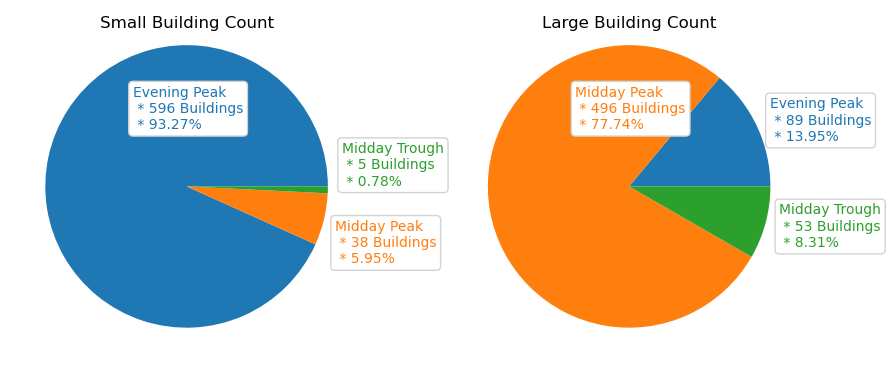

In [15]:
eda.plot_first_level_energy_fractions(cluster_data)
eda.plot_first_level_count_fractions(cluster_data)

<a id="PieChart"></a>
<div style="text-align: center;">
    <h2>Plot 8: Energy Consumptions Breakdown</h2>
</div>

In [ ]:
# eda.plot_group_hierarchy(cluster_data)

![final_hierarchy.png](final_hierarchy.png)

<a id="Hierarchy"></a>
<div style="text-align: center;">
    <h2>Figure 1: Energy Consumptions Hierarchy</h2>
</div>

## Potential DR Program
This is the final hierarchy of the "clusters" (recall, some buildings have both a summer peak and winter peak and so they are part of both "clusters"). The final clusters correspond to the leaves in the tree and are highlighted in color. Let's discuss the potential DR program for each cluster:

* Large Summer Midday Peak (blue):
The large summer midday peak cluster has the largest contribution to overall consumption. Most of these buildings are likely commercial buildings with cooling loads, as seen in the energy consumption profile in [Plot 9](FinalCluster). To reduce peak demand during midday in summer, encouraging these buildings to use more efficient cooling systems can be a good start. Additionally, scheduling the turning on of cooling systems can smooth energy consumption and reduce the need for expensive peaker power plants. Many large commercial buildings are equipped with emergency generators that often remain idle. Utilizing these generators during peak consumption periods can reduce the net load [[4]](#Paper). Lastly, adjusting prices during high and low demand periods can incentivize careful energy consumption management.

* Large Winter Midday Peak (orange):
The large winter midday peak cluster has a similar daily profile to the large summer midday peak cluster, but occurs during winter months. Heating loads mainly account for total energy consumption during this time. Transitioning to more efficient heating solutions such as heat pumps could help reduce peak load [[5]](#Paper). Similarly to the previous cluster, careful scheduling can reduce reliance on peaker power, lowering electricity costs. Emergency generators can also be utilized when needed to reduce net load. Overall, reducing peak load and ramping energy consumption during summer and winter midday peaks can reduce peak power demand, the need of peaker generator, and electricity prices.

* Large Midday Trough (purple):
This cluster is unique compared to others. As shown in [Plot 9](FinalCluster), there is a strong indication of solar power presence in these buildings. This implies that they are likely to participate in the DR program as they are already focused on energy saving. Targeting these buildings as a priority is crucial for the success of the DR program. Additionally, installing batteries (if not already present) can reduce peak load during high demand periods by charging them when solar energy is abundant.

* Summer Evening Peak (green):
The summer evening peak cluster consists of both large and small buildings. As mentioned earlier, these buildings are grouped together due to their similar energy consumption patterns, as shown in [Plot 9](FinalCluster). Implementing a DR program such as time-of-use (ToU) pricing rate structures can be effective for this cluster. Since small buildings contribute the most to the number of buildings in this cluster, managing them individually may be challenging. An aggregator can facilitate their participation in the DR program, ensuring equity in energy savings.

* Winter Evening Peak (red):
The winter evening peak cluster exhibits a similar energy consumption pattern to the summer evening peak cluster. Therefore, the same DR program can be implemented for this cluster.

Finally, there are 43 buildings from the small midday peak and midday trough category that are not included in any clusters. The number of buildings and energy consumption from these clusters is too small to warrant their own DR program. However, this doesn't mean that these buildings cannot participate in a DR program. In fact, the small midday trough buildings can participate in the DR program with the large midday trough buildings, and similarly, small midday peak buildings can participate in DR with large midday peak buildings. Of course, their involvement in the DR program will be facilitated through an aggregator.

In [17]:
final_cluster_info = fe.get_final_cluster_info(cluster_data)
final_cluster_info.to_csv("final_cluster_info.csv", index=False)

display_names = ["DR Program Type", "Total Group Consumption (GWh)", "Average Building Consumption (GWh)", "Building Count", "Building IDs"]
utils.display_dataframe(final_cluster_info.rename(columns={x:display_names[i] for i,x in enumerate(final_cluster_info)}).iloc[:, :-1])

DR Program Type,Total Group Consumption (GWh),Average Building Consumption (GWh),Building Count
Large Summer Midday Peak,664.458638,2.050798,324
Large Winter Midday Peak,365.540335,1.044401,350
Large Midday Trough,47.436622,0.895031,53
Summer Evening Peak,38.304019,0.136800,280
Winter Evening Peak,74.829337,0.135315,553


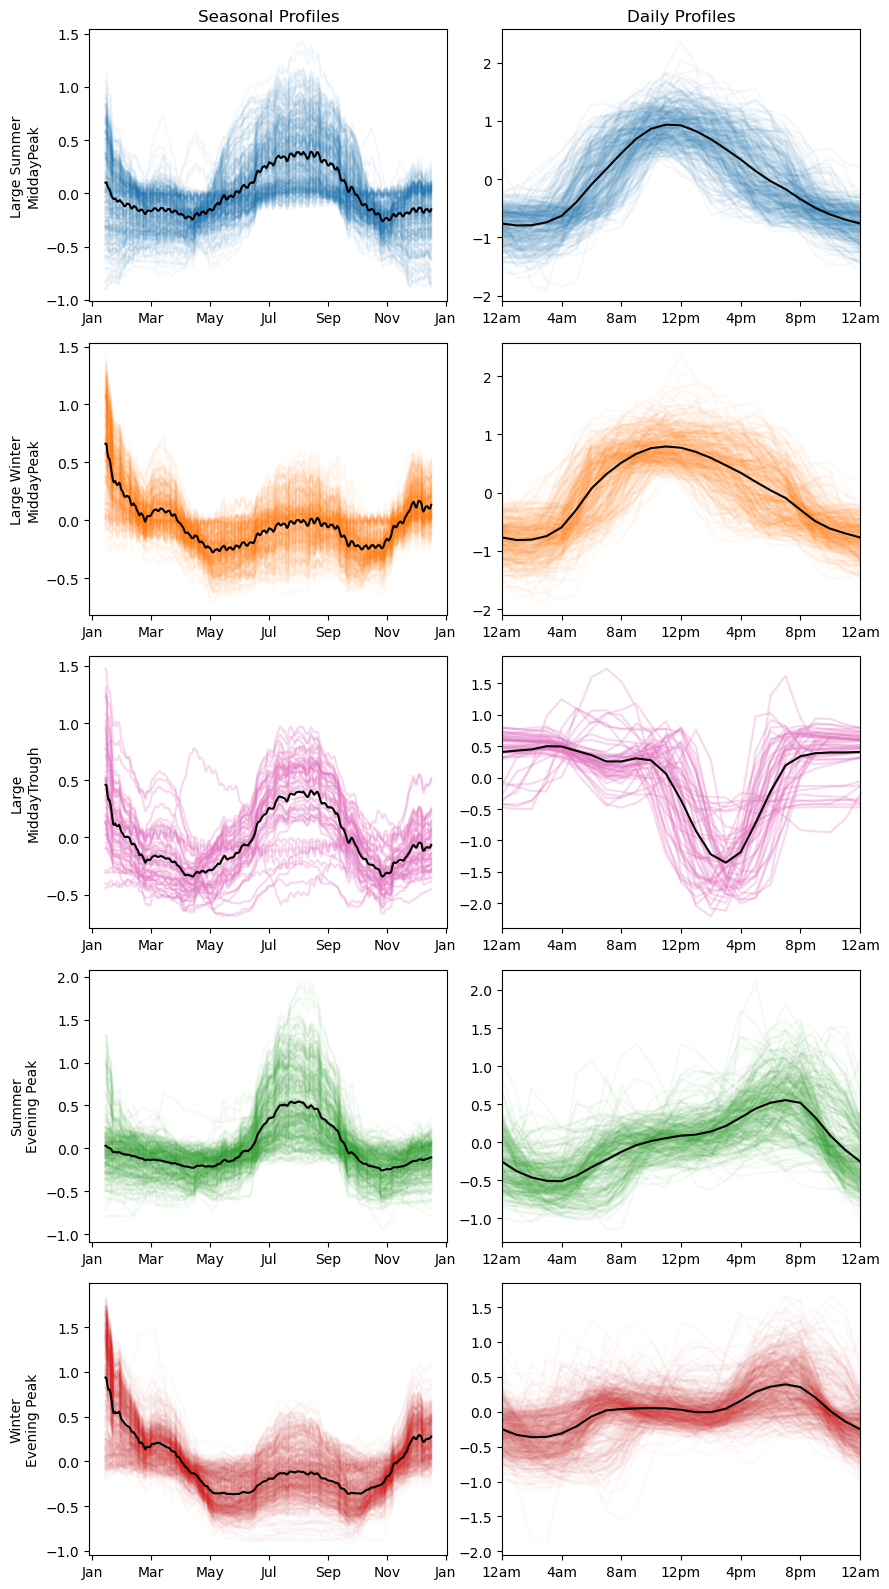

In [64]:
eda.plot_final_clusters(final_cluster_info, raw_seasonal_features, raw_daily_features, seasonal_features, daily_features)

<a id="FinalCluster"></a>
<div style="text-align: center;">
    <h2>Plot 9: Final Cluster</h2>
</div>

## 5. Conclusion
A total of five clusters were created based on similarity in energy consumption patterns. Potential DR programs are proposed to maximize energy savings through methods such as shifting energy usage, time-of-use pricing, and peak load reduction. Our programs for large buildings cover the critical cases of midday peak, midday trough, and evening peak. All small buildings are included in DR programs, which promotes equity. This comprehensive approach ensures that both large and small consumers can participate meaningfully in demand response initiatives. By including diverse building types and usage patterns, our strategy aims to create a balanced and effective DR program.

Our analysis involved many manual steps and subjective engineering judgment. In the future, it would be interesting to automate some of these steps through alternative approaches. Additionally, a fully automated black-box approach could offer new insights for creating effective DR programs. This could enhance the scalability and adaptability of our methodology, making it more efficient and comprehensive.

## 6. Reference
<a id="Paper"></a>
[1] Sotiris Pelekis, et al. "Targeted Demand Response for Flexible Energy Communities Using Clustering Techniques."

[2] Toussaint, Wiebke  and  Moodley, Deshendran "Comparison of clustering techniques for residential load profiles in South Africa"

[3] Ramos, S., et al. "Typical load profiles in the smart grid context — A clustering methods comparison," 2012 IEEE Power and Energy 
Society General Meeting, San Diego, CA, USA, 2012

[4] Leger, Aaron "Demand response impacts on off-grid hybrid photovoltaic-diesel generator microgrids"

[5] J. S. Hlakotsa, M. J. Lencwe, A. Ngobeni and S. D. Chowdhury, "Energy Efficient Water Heating using Air Source Heat Pumps," 2019 IEEE AFRICON, Accra, Ghana, 2019